In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [2]:
def preprocess_data(file_path, target_column):
    df = pd.read_csv(file_path)
    
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")
    
    y = df[target_column]
    df = df.drop(columns=[target_column])
    
    date_columns = ['list_date', 'sold_date']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    categorical_columns = [col for col in categorical_columns if col not in date_columns]
    
    for col in categorical_columns:
        df[col] = df[col].astype(str).fillna('Unknown')
    
    numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
    
    for col in numerical_columns:
        df[col] = df[col].fillna(df[col].median())
    
    transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),
        ('scaler', StandardScaler(), numerical_columns)
    ])
    
    pipeline = Pipeline([
        ('transform', transformer)
    ])
    
    df_encoded = pipeline.fit_transform(df)
    
    if hasattr(df_encoded, 'toarray'):
        df_encoded = df_encoded.toarray()
    
    df_encoded = pd.DataFrame(df_encoded, columns=pipeline.get_feature_names_out())
    
    df_encoded[target_column] = y.values
    
    return df_encoded

In [3]:
file_path = os.getcwd() + "\\..\\csvFiles\\cleaned_data.csv"
target_column = "sold_price"
df_processed = preprocess_data(file_path, target_column)

In [4]:
df_processed = df_processed.apply(pd.to_numeric, errors='coerce').fillna(0)

In [5]:
X = df_processed.drop(columns=[target_column])
y = df_processed[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                      random_state=42)

In [7]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

Mean Squared Error: 70341344252.25125
R-Squared: 0.7953372476928415


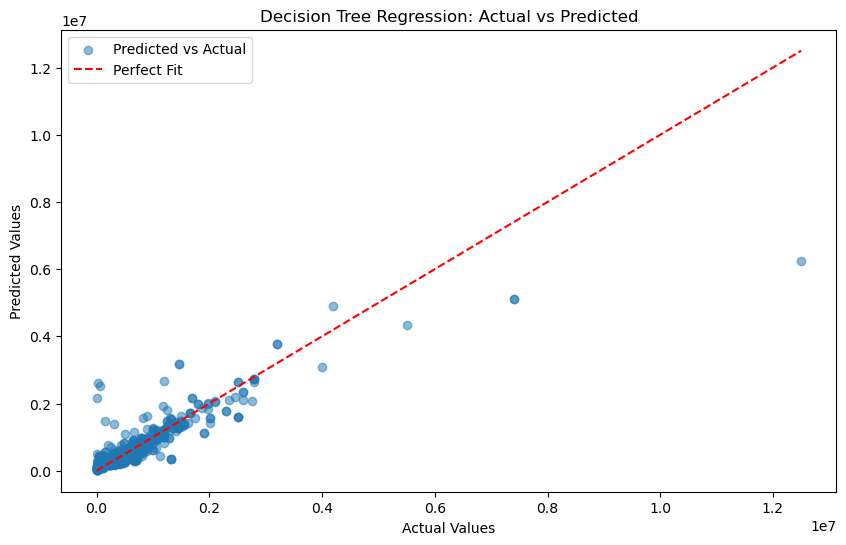

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree Regression: Actual vs Predicted")
plt.legend()
plt.show()